In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 16, 100, 100))

In [12]:
image = 1-image/100

In [13]:
image.shape

(133, 16, 100, 100)

In [14]:
image[0,0,:,:]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

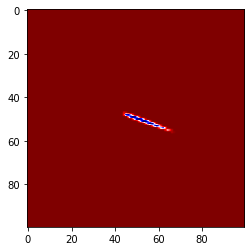

In [15]:
aaa=plt.imshow(image[0,15,:,:].T, cmap='seismic')
aaa.colorbar

In [16]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [17]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [18]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [19]:
y = y.reshape((133, 16, 2, 1))

In [20]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [21]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [22]:
geometry.shape

(2128, 1)

In [23]:
geometry = geometry.reshape((133, 16, 1))

In [24]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [25]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [26]:
x_train.shape

(2016, 100, 100, 1)

In [27]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 100)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 250000)            0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               50000200  
                                                                 
 secondHiddenLayer (Dense)   (None, 100)               20100     
                                                             

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 15s 12ms/step - loss: 5.4091 - rmse: 2.3258
Epoch 2/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0455 - rmse: 0.2133
Epoch 3/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0166 - rmse: 0.1288
Epoch 4/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0148 - rmse: 0.1215
Epoch 5/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0233 - rmse: 0.1527
Epoch 6/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0161 - rmse: 0.1267
Epoch 7/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0111 - rmse: 0.1052
Epoch 8/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0174 - rmse: 0.1319
Epoch 9/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0104 - rmse: 0.1019
Epoch 10/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0092 - rmse: 0.0960
Epoch 11/5000
63/63 [=======

63/63 [==============================] - 1s 12ms/step - loss: 0.0039 - rmse: 0.0626
Epoch 85/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0042 - rmse: 0.0647
Epoch 86/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0039 - rmse: 0.0621
Epoch 87/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0049 - rmse: 0.0697
Epoch 88/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0040 - rmse: 0.0632
Epoch 89/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0039 - rmse: 0.0625
Epoch 90/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0039 - rmse: 0.0627
Epoch 91/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0039 - rmse: 0.0626
Epoch 92/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0042 - rmse: 0.0649
Epoch 93/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0038 - rmse: 0.0613
Epoch 94/5000
63/63 [=============

63/63 [==============================] - 1s 12ms/step - loss: 0.0040 - rmse: 0.0628
Epoch 168/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0038 - rmse: 0.0616
Epoch 169/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0037 - rmse: 0.0610
Epoch 170/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0036 - rmse: 0.0600
Epoch 171/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0036 - rmse: 0.0602
Epoch 172/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0043 - rmse: 0.0659
Epoch 173/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0041 - rmse: 0.0643
Epoch 174/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0040 - rmse: 0.0631
Epoch 175/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0038 - rmse: 0.0618
Epoch 176/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0038 - rmse: 0.0615
Epoch 177/5000
63/63 [===

63/63 [==============================] - 1s 12ms/step - loss: 0.0031 - rmse: 0.0553
Epoch 250/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0027 - rmse: 0.0520
Epoch 251/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0026 - rmse: 0.0513
Epoch 252/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0026 - rmse: 0.0514
Epoch 253/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0025 - rmse: 0.0504
Epoch 254/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0026 - rmse: 0.0507
Epoch 255/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0025 - rmse: 0.0504
Epoch 256/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0028 - rmse: 0.0524
Epoch 257/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0027 - rmse: 0.0521
Epoch 258/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0025 - rmse: 0.0504
Epoch 259/5000
63/63 [===

63/63 [==============================] - 1s 12ms/step - loss: 0.0018 - rmse: 0.0429
Epoch 332/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0020 - rmse: 0.0444
Epoch 333/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 334/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0019 - rmse: 0.0433
Epoch 335/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0018 - rmse: 0.0428
Epoch 336/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 337/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0018 - rmse: 0.0424
Epoch 338/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0018 - rmse: 0.0428
Epoch 339/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 340/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0017 - rmse: 0.0417
Epoch 341/5000
63/63 [===

63/63 [==============================] - 1s 12ms/step - loss: 0.0013 - rmse: 0.0360
Epoch 414/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0012 - rmse: 0.0350
Epoch 415/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0015 - rmse: 0.0388
Epoch 416/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0014 - rmse: 0.0374
Epoch 417/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0013 - rmse: 0.0358
Epoch 418/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0013 - rmse: 0.0362
Epoch 419/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0015 - rmse: 0.0384
Epoch 420/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0014 - rmse: 0.0371
Epoch 421/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0014 - rmse: 0.0371
Epoch 422/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0013 - rmse: 0.0358
Epoch 423/5000
63/63 [===

63/63 [==============================] - 1s 12ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 496/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.9832e-04 - rmse: 0.0316
Epoch 497/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.3702e-04 - rmse: 0.0306
Epoch 498/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.6912e-04 - rmse: 0.0311
Epoch 499/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 500/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.0652e-04 - rmse: 0.0301
Epoch 501/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.8304e-04 - rmse: 0.0313
Epoch 502/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 503/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.6591e-04 - rmse: 0.0310
Epoch 504/5000
63/63 [==============================] - 1s 12ms/step - loss: 0.0011 - rmse: 0.0327
E

63/63 [==============================] - 1s 12ms/step - loss: 7.6074e-04 - rmse: 0.0275
Epoch 576/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.4197e-04 - rmse: 0.0272
Epoch 577/5000
63/63 [==============================] - 1s 12ms/step - loss: 8.1149e-04 - rmse: 0.0284
Epoch 578/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.5142e-04 - rmse: 0.0274
Epoch 579/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.0175e-04 - rmse: 0.0264
Epoch 580/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.8278e-04 - rmse: 0.0313
Epoch 581/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.5733e-04 - rmse: 0.0309
Epoch 582/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.9882e-04 - rmse: 0.0282
Epoch 583/5000
63/63 [==============================] - 1s 12ms/step - loss: 8.1831e-04 - rmse: 0.0286
Epoch 584/5000
63/63 [==============================] - 1s 12ms/step - loss: 8.2349e-04 

63/63 [==============================] - 1s 12ms/step - loss: 8.3245e-04 - rmse: 0.0288
Epoch 655/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.7047e-04 - rmse: 0.0259
Epoch 656/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.3615e-04 - rmse: 0.0271
Epoch 657/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.4797e-04 - rmse: 0.0254
Epoch 658/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.3855e-04 - rmse: 0.0252
Epoch 659/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.6447e-04 - rmse: 0.0257
Epoch 660/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.7917e-04 - rmse: 0.0260
Epoch 661/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.2918e-04 - rmse: 0.0270
Epoch 662/5000
63/63 [==============================] - 1s 12ms/step - loss: 8.0050e-04 - rmse: 0.0283
Epoch 663/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.1677e-04 

63/63 [==============================] - 1s 12ms/step - loss: 5.8987e-04 - rmse: 0.0242
Epoch 734/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.4852e-04 - rmse: 0.0234
Epoch 735/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.0798e-04 - rmse: 0.0246
Epoch 736/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.1780e-04 - rmse: 0.0248
Epoch 737/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.2991e-04 - rmse: 0.0251
Epoch 738/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.2548e-04 - rmse: 0.0250
Epoch 739/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.4346e-04 - rmse: 0.0233
Epoch 740/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.5807e-04 - rmse: 0.0236
Epoch 741/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.3383e-04 - rmse: 0.0231
Epoch 742/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.0183e-04 

63/63 [==============================] - 1s 12ms/step - loss: 6.5928e-04 - rmse: 0.0256
Epoch 813/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.7456e-04 - rmse: 0.0239
Epoch 814/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.6734e-04 - rmse: 0.0238
Epoch 815/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.1678e-04 - rmse: 0.0248
Epoch 816/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.2508e-04 - rmse: 0.0229
Epoch 817/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.6646e-04 - rmse: 0.0238
Epoch 818/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.5671e-04 - rmse: 0.0213
Epoch 819/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.7076e-04 - rmse: 0.0238
Epoch 820/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.1548e-04 - rmse: 0.0227
Epoch 821/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.6326e-04 

63/63 [==============================] - 1s 12ms/step - loss: 4.6438e-04 - rmse: 0.0215
Epoch 892/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.8821e-04 - rmse: 0.0221
Epoch 893/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.1309e-04 - rmse: 0.0267
Epoch 894/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.7556e-04 - rmse: 0.0218
Epoch 895/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.3808e-04 - rmse: 0.0209
Epoch 896/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.7858e-04 - rmse: 0.0240
Epoch 897/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.1501e-04 - rmse: 0.0227
Epoch 898/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.8619e-04 - rmse: 0.0220
Epoch 899/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.7161e-04 - rmse: 0.0217
Epoch 900/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.9897e-04 

63/63 [==============================] - 1s 12ms/step - loss: 4.6301e-04 - rmse: 0.0215
Epoch 971/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.9385e-04 - rmse: 0.0198
Epoch 972/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.7140e-04 - rmse: 0.0217
Epoch 973/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.0127e-04 - rmse: 0.0223
Epoch 974/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.8908e-04 - rmse: 0.0242
Epoch 975/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.0235e-04 - rmse: 0.0265
Epoch 976/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.7091e-04 - rmse: 0.0217
Epoch 977/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.4049e-04 - rmse: 0.0232
Epoch 978/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.7099e-04 - rmse: 0.0217
Epoch 979/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.7275e-04 

63/63 [==============================] - 1s 12ms/step - loss: 4.9194e-04 - rmse: 0.0221
Epoch 1050/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4925e-04 - rmse: 0.0211
Epoch 1051/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4501e-04 - rmse: 0.0210
Epoch 1052/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.3292e-04 - rmse: 0.0230
Epoch 1053/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.4352e-04 - rmse: 0.0233
Epoch 1054/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.6635e-04 - rmse: 0.0216
Epoch 1055/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4911e-04 - rmse: 0.0211
Epoch 1056/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.5125e-04 - rmse: 0.0212
Epoch 1057/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8943e-04 - rmse: 0.0197
Epoch 1058/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.

Epoch 1128/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.7793e-04 - rmse: 0.0194
Epoch 1129/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.6517e-04 - rmse: 0.0191
Epoch 1130/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4954e-04 - rmse: 0.0212
Epoch 1131/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.0976e-04 - rmse: 0.0225
Epoch 1132/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.6585e-04 - rmse: 0.0191
Epoch 1133/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.7597e-04 - rmse: 0.0193
Epoch 1134/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.1808e-04 - rmse: 0.0204
Epoch 1135/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.3534e-04 - rmse: 0.0208
Epoch 1136/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.5195e-04 - rmse: 0.0212
Epoch 1137/5000
63/63 [==============================] - 1s 12ms

63/63 [==============================] - 1s 12ms/step - loss: 3.6683e-04 - rmse: 0.0191
Epoch 1207/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.9545e-04 - rmse: 0.0198
Epoch 1208/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5927e-04 - rmse: 0.0189
Epoch 1209/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.4428e-04 - rmse: 0.0185
Epoch 1210/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.9266e-04 - rmse: 0.0198
Epoch 1211/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8073e-04 - rmse: 0.0195
Epoch 1212/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.9790e-04 - rmse: 0.0199
Epoch 1213/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5344e-04 - rmse: 0.0187
Epoch 1214/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8029e-04 - rmse: 0.0194
Epoch 1215/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.

63/63 [==============================] - 1s 12ms/step - loss: 3.8315e-04 - rmse: 0.0195
Epoch 1285/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8288e-04 - rmse: 0.0195
Epoch 1286/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.2162e-04 - rmse: 0.0205
Epoch 1287/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.4703e-04 - rmse: 0.0233
Epoch 1288/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.1827e-04 - rmse: 0.0227
Epoch 1289/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.5721e-04 - rmse: 0.0213
Epoch 1290/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.2461e-04 - rmse: 0.0229
Epoch 1291/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.4763e-04 - rmse: 0.0186
Epoch 1292/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.7928e-04 - rmse: 0.0194
Epoch 1293/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.

63/63 [==============================] - 1s 12ms/step - loss: 3.2910e-04 - rmse: 0.0181
Epoch 1363/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.3930e-04 - rmse: 0.0184
Epoch 1364/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0844e-04 - rmse: 0.0175
Epoch 1365/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5028e-04 - rmse: 0.0187
Epoch 1366/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.2090e-04 - rmse: 0.0179
Epoch 1367/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4631e-04 - rmse: 0.0211
Epoch 1368/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.6655e-04 - rmse: 0.0216
Epoch 1369/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0063e-04 - rmse: 0.0173
Epoch 1370/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.0685e-04 - rmse: 0.0201
Epoch 1371/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.

63/63 [==============================] - 1s 12ms/step - loss: 4.5388e-04 - rmse: 0.0213
Epoch 1441/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5312e-04 - rmse: 0.0187
Epoch 1442/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.2887e-04 - rmse: 0.0181
Epoch 1443/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0468e-04 - rmse: 0.0174
Epoch 1444/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1169e-04 - rmse: 0.0176
Epoch 1445/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0707e-04 - rmse: 0.0175
Epoch 1446/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.4799e-04 - rmse: 0.0186
Epoch 1447/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8536e-04 - rmse: 0.0196
Epoch 1448/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8503e-04 - rmse: 0.0196
Epoch 1449/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 3.2464e-04 - rmse: 0.0180
Epoch 1519/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1787e-04 - rmse: 0.0178
Epoch 1520/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5659e-04 - rmse: 0.0188
Epoch 1521/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4318e-04 - rmse: 0.0210
Epoch 1522/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.0281e-04 - rmse: 0.0200
Epoch 1523/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.7514e-04 - rmse: 0.0193
Epoch 1524/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.3255e-04 - rmse: 0.0182
Epoch 1525/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7235e-04 - rmse: 0.0164
Epoch 1526/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.8592e-04 - rmse: 0.0168
Epoch 1527/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.

63/63 [==============================] - 1s 12ms/step - loss: 2.8457e-04 - rmse: 0.0168
Epoch 1597/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7488e-04 - rmse: 0.0165
Epoch 1598/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0205e-04 - rmse: 0.0173
Epoch 1599/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0337e-04 - rmse: 0.0174
Epoch 1600/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9480e-04 - rmse: 0.0171
Epoch 1601/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6943e-04 - rmse: 0.0163
Epoch 1602/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.8967e-04 - rmse: 0.0197
Epoch 1603/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.8721e-04 - rmse: 0.0220
Epoch 1604/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5362e-04 - rmse: 0.0187
Epoch 1605/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 4.8881e-04 - rmse: 0.0221
Epoch 1675/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.5769e-04 - rmse: 0.0189
Epoch 1676/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.8317e-04 - rmse: 0.0168
Epoch 1677/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9737e-04 - rmse: 0.0172
Epoch 1678/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7840e-04 - rmse: 0.0166
Epoch 1679/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4585e-04 - rmse: 0.0156
Epoch 1680/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6910e-04 - rmse: 0.0163
Epoch 1681/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9438e-04 - rmse: 0.0171
Epoch 1682/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7953e-04 - rmse: 0.0167
Epoch 1683/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 3.1942e-04 - rmse: 0.0178
Epoch 1754/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.0698e-04 - rmse: 0.0201
Epoch 1755/5000
63/63 [==============================] - 1s 12ms/step - loss: 5.7573e-04 - rmse: 0.0239
Epoch 1756/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.7841e-04 - rmse: 0.0194
Epoch 1757/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.4990e-04 - rmse: 0.0186
Epoch 1758/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.5579e-04 - rmse: 0.0213
Epoch 1759/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.6432e-04 - rmse: 0.0190
Epoch 1760/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4292e-04 - rmse: 0.0155
Epoch 1761/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6227e-04 - rmse: 0.0161
Epoch 1762/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 4.9890e-04 - rmse: 0.0223
Epoch 1832/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1697e-04 - rmse: 0.0177
Epoch 1833/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9291e-04 - rmse: 0.0170
Epoch 1834/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2845e-04 - rmse: 0.0150
Epoch 1835/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3728e-04 - rmse: 0.0153
Epoch 1836/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4645e-04 - rmse: 0.0156
Epoch 1837/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2988e-04 - rmse: 0.0151
Epoch 1838/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4061e-04 - rmse: 0.0154
Epoch 1839/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2770e-04 - rmse: 0.0150
Epoch 1840/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.6423e-04 - rmse: 0.0162
Epoch 1910/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3430e-04 - rmse: 0.0152
Epoch 1911/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3188e-04 - rmse: 0.0151
Epoch 1912/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5705e-04 - rmse: 0.0160
Epoch 1913/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5877e-04 - rmse: 0.0160
Epoch 1914/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7492e-04 - rmse: 0.0165
Epoch 1915/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.8412e-04 - rmse: 0.0168
Epoch 1916/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.2984e-04 - rmse: 0.0181
Epoch 1917/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.6167e-04 - rmse: 0.0190
Epoch 1918/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.

63/63 [==============================] - 1s 12ms/step - loss: 2.2255e-04 - rmse: 0.0148
Epoch 1988/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9268e-04 - rmse: 0.0138
Epoch 1989/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5828e-04 - rmse: 0.0160
Epoch 1990/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3618e-04 - rmse: 0.0153
Epoch 1991/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2022e-04 - rmse: 0.0148
Epoch 1992/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0936e-04 - rmse: 0.0144
Epoch 1993/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1817e-04 - rmse: 0.0178
Epoch 1994/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7518e-04 - rmse: 0.0165
Epoch 1995/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7874e-04 - rmse: 0.0166
Epoch 1996/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.0122e-04 - rmse: 0.0141
Epoch 2066/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4516e-04 - rmse: 0.0156
Epoch 2067/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5090e-04 - rmse: 0.0158
Epoch 2068/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4573e-04 - rmse: 0.0156
Epoch 2069/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2437e-04 - rmse: 0.0149
Epoch 2070/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5007e-04 - rmse: 0.0157
Epoch 2071/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4375e-04 - rmse: 0.0155
Epoch 2072/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6409e-04 - rmse: 0.0162
Epoch 2073/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3369e-04 - rmse: 0.0152
Epoch 2074/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 4.0332e-04 - rmse: 0.0200
Epoch 2144/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.2899e-04 - rmse: 0.0206
Epoch 2145/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3169e-04 - rmse: 0.0151
Epoch 2146/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1402e-04 - rmse: 0.0145
Epoch 2147/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6429e-04 - rmse: 0.0162
Epoch 2148/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2914e-04 - rmse: 0.0151
Epoch 2149/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3423e-04 - rmse: 0.0152
Epoch 2150/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2870e-04 - rmse: 0.0150
Epoch 2151/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1509e-04 - rmse: 0.0146
Epoch 2152/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.5888e-04 - rmse: 0.0160
Epoch 2222/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4874e-04 - rmse: 0.0157
Epoch 2223/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5160e-04 - rmse: 0.0158
Epoch 2224/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6683e-04 - rmse: 0.0163
Epoch 2225/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7730e-04 - rmse: 0.0166
Epoch 2226/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1349e-04 - rmse: 0.0176
Epoch 2227/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6188e-04 - rmse: 0.0161
Epoch 2228/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3469e-04 - rmse: 0.0152
Epoch 2229/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9425e-04 - rmse: 0.0171
Epoch 2230/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 3.1803e-04 - rmse: 0.0178
Epoch 2300/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.8427e-04 - rmse: 0.0168
Epoch 2301/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4468e-04 - rmse: 0.0156
Epoch 2302/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0432e-04 - rmse: 0.0142
Epoch 2303/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0036e-04 - rmse: 0.0141
Epoch 2304/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9785e-04 - rmse: 0.0140
Epoch 2305/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9156e-04 - rmse: 0.0170
Epoch 2306/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7731e-04 - rmse: 0.0166
Epoch 2307/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3211e-04 - rmse: 0.0151
Epoch 2308/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.8149e-04 - rmse: 0.0167
Epoch 2378/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3533e-04 - rmse: 0.0153
Epoch 2379/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0948e-04 - rmse: 0.0144
Epoch 2380/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8649e-04 - rmse: 0.0136
Epoch 2381/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8447e-04 - rmse: 0.0135
Epoch 2382/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6989e-04 - rmse: 0.0129
Epoch 2383/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7051e-04 - rmse: 0.0130
Epoch 2384/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8587e-04 - rmse: 0.0135
Epoch 2385/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2673e-04 - rmse: 0.0150
Epoch 2386/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 5.2206e-04 - rmse: 0.0228
Epoch 2456/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1557e-04 - rmse: 0.0177
Epoch 2457/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3647e-04 - rmse: 0.0153
Epoch 2458/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1244e-04 - rmse: 0.0145
Epoch 2459/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2510e-04 - rmse: 0.0149
Epoch 2460/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2293e-04 - rmse: 0.0148
Epoch 2461/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3877e-04 - rmse: 0.0154
Epoch 2462/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4974e-04 - rmse: 0.0157
Epoch 2463/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2096e-04 - rmse: 0.0148
Epoch 2464/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.0558e-04 - rmse: 0.0142
Epoch 2534/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2228e-04 - rmse: 0.0148
Epoch 2535/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1636e-04 - rmse: 0.0146
Epoch 2536/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0139e-04 - rmse: 0.0141
Epoch 2537/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0024e-04 - rmse: 0.0140
Epoch 2538/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0455e-04 - rmse: 0.0142
Epoch 2539/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6026e-04 - rmse: 0.0160
Epoch 2540/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1233e-04 - rmse: 0.0145
Epoch 2541/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1551e-04 - rmse: 0.0146
Epoch 2542/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.4114e-04 - rmse: 0.0154
Epoch 2612/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.2196e-04 - rmse: 0.0205
Epoch 2613/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4540e-04 - rmse: 0.0156
Epoch 2614/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6420e-04 - rmse: 0.0162
Epoch 2615/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0171e-04 - rmse: 0.0141
Epoch 2616/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8272e-04 - rmse: 0.0134
Epoch 2617/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7657e-04 - rmse: 0.0132
Epoch 2618/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5548e-04 - rmse: 0.0124
Epoch 2619/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6288e-04 - rmse: 0.0126
Epoch 2620/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 3.5181e-04 - rmse: 0.0187
Epoch 2690/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5483e-04 - rmse: 0.0159
Epoch 2691/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9138e-04 - rmse: 0.0137
Epoch 2692/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8655e-04 - rmse: 0.0136
Epoch 2693/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8273e-04 - rmse: 0.0134
Epoch 2694/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0004e-04 - rmse: 0.0140
Epoch 2695/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3192e-04 - rmse: 0.0151
Epoch 2696/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0917e-04 - rmse: 0.0144
Epoch 2697/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1249e-04 - rmse: 0.0145
Epoch 2698/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.8712e-04 - rmse: 0.0136
Epoch 2768/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8315e-04 - rmse: 0.0134
Epoch 2769/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8547e-04 - rmse: 0.0135
Epoch 2770/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8120e-04 - rmse: 0.0133
Epoch 2771/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7606e-04 - rmse: 0.0132
Epoch 2772/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4000e-04 - rmse: 0.0154
Epoch 2773/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0690e-04 - rmse: 0.0143
Epoch 2774/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5788e-04 - rmse: 0.0160
Epoch 2775/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9523e-04 - rmse: 0.0171
Epoch 2776/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.

63/63 [==============================] - 1s 12ms/step - loss: 1.6044e-04 - rmse: 0.0125
Epoch 2846/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6767e-04 - rmse: 0.0128
Epoch 2847/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6867e-04 - rmse: 0.0129
Epoch 2848/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7636e-04 - rmse: 0.0132
Epoch 2849/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7587e-04 - rmse: 0.0131
Epoch 2850/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5809e-04 - rmse: 0.0125
Epoch 2851/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9350e-04 - rmse: 0.0138
Epoch 2852/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1841e-04 - rmse: 0.0147
Epoch 2853/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8941e-04 - rmse: 0.0137
Epoch 2854/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 2.8514e-04 - rmse: 0.0168
Epoch 2924/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5421e-04 - rmse: 0.0158
Epoch 2925/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9060e-04 - rmse: 0.0137
Epoch 2926/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6949e-04 - rmse: 0.0129
Epoch 2927/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6422e-04 - rmse: 0.0127
Epoch 2928/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7223e-04 - rmse: 0.0130
Epoch 2929/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7286e-04 - rmse: 0.0130
Epoch 2930/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8718e-04 - rmse: 0.0136
Epoch 2931/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9042e-04 - rmse: 0.0137
Epoch 2932/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 1.9803e-04 - rmse: 0.0140
Epoch 3002/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.8479e-04 - rmse: 0.0168
Epoch 3003/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3074e-04 - rmse: 0.0151
Epoch 3004/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9815e-04 - rmse: 0.0140
Epoch 3005/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7928e-04 - rmse: 0.0133
Epoch 3006/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7453e-04 - rmse: 0.0131
Epoch 3007/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9462e-04 - rmse: 0.0138
Epoch 3008/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8818e-04 - rmse: 0.0136
Epoch 3009/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1775e-04 - rmse: 0.0146
Epoch 3010/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 3.6520e-04 - rmse: 0.0190
Epoch 3080/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.5406e-04 - rmse: 0.0158
Epoch 3081/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0225e-04 - rmse: 0.0141
Epoch 3082/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9577e-04 - rmse: 0.0139
Epoch 3083/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6285e-04 - rmse: 0.0126
Epoch 3084/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7661e-04 - rmse: 0.0132
Epoch 3085/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0422e-04 - rmse: 0.0142
Epoch 3086/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3594e-04 - rmse: 0.0153
Epoch 3087/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8412e-04 - rmse: 0.0135
Epoch 3088/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 2.3760e-04 - rmse: 0.0153
Epoch 3158/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9682e-04 - rmse: 0.0139
Epoch 3159/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3331e-04 - rmse: 0.0152
Epoch 3160/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1327e-04 - rmse: 0.0145
Epoch 3161/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6930e-04 - rmse: 0.0129
Epoch 3162/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4204e-04 - rmse: 0.0155
Epoch 3163/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.4302e-04 - rmse: 0.0184
Epoch 3164/5000
63/63 [==============================] - 1s 12ms/step - loss: 7.1695e-04 - rmse: 0.0267
Epoch 3165/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.9173e-04 - rmse: 0.0221
Epoch 3166/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.

63/63 [==============================] - 1s 12ms/step - loss: 1.7898e-04 - rmse: 0.0133
Epoch 3236/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3488e-04 - rmse: 0.0152
Epoch 3237/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9749e-04 - rmse: 0.0139
Epoch 3238/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0033e-04 - rmse: 0.0140
Epoch 3239/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8542e-04 - rmse: 0.0135
Epoch 3240/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6591e-04 - rmse: 0.0128
Epoch 3241/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9420e-04 - rmse: 0.0138
Epoch 3242/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8647e-04 - rmse: 0.0135
Epoch 3243/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9981e-04 - rmse: 0.0140
Epoch 3244/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 2.0771e-04 - rmse: 0.0143
Epoch 3314/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7875e-04 - rmse: 0.0132
Epoch 3315/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7982e-04 - rmse: 0.0133
Epoch 3316/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7573e-04 - rmse: 0.0131
Epoch 3317/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8512e-04 - rmse: 0.0135
Epoch 3318/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7056e-04 - rmse: 0.0129
Epoch 3319/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1356e-04 - rmse: 0.0145
Epoch 3320/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0510e-04 - rmse: 0.0142
Epoch 3321/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.4315e-04 - rmse: 0.0184
Epoch 3322/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.

63/63 [==============================] - 1s 12ms/step - loss: 1.8650e-04 - rmse: 0.0135
Epoch 3392/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0011e-04 - rmse: 0.0140
Epoch 3393/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0022e-04 - rmse: 0.0140
Epoch 3394/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2531e-04 - rmse: 0.0149
Epoch 3395/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9601e-04 - rmse: 0.0139
Epoch 3396/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9318e-04 - rmse: 0.0138
Epoch 3397/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7349e-04 - rmse: 0.0130
Epoch 3398/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2226e-04 - rmse: 0.0148
Epoch 3399/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9820e-04 - rmse: 0.0140
Epoch 3400/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.7221e-04 - rmse: 0.0130
Epoch 3470/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6705e-04 - rmse: 0.0128
Epoch 3471/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7582e-04 - rmse: 0.0131
Epoch 3472/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5958e-04 - rmse: 0.0125
Epoch 3473/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7342e-04 - rmse: 0.0130
Epoch 3474/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3808e-04 - rmse: 0.0153
Epoch 3475/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3090e-04 - rmse: 0.0151
Epoch 3476/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9385e-04 - rmse: 0.0170
Epoch 3477/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6116e-04 - rmse: 0.0161
Epoch 3478/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 1.7484e-04 - rmse: 0.0131
Epoch 3548/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7007e-04 - rmse: 0.0129
Epoch 3549/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7417e-04 - rmse: 0.0131
Epoch 3550/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7202e-04 - rmse: 0.0130
Epoch 3551/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5969e-04 - rmse: 0.0125
Epoch 3552/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6267e-04 - rmse: 0.0126
Epoch 3553/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7701e-04 - rmse: 0.0132
Epoch 3554/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7971e-04 - rmse: 0.0166
Epoch 3555/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.7327e-04 - rmse: 0.0192
Epoch 3556/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.

63/63 [==============================] - 1s 12ms/step - loss: 1.9791e-04 - rmse: 0.0139
Epoch 3626/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9456e-04 - rmse: 0.0138
Epoch 3627/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9326e-04 - rmse: 0.0138
Epoch 3628/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9968e-04 - rmse: 0.0140
Epoch 3629/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3504e-04 - rmse: 0.0152
Epoch 3630/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4736e-04 - rmse: 0.0156
Epoch 3631/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0490e-04 - rmse: 0.0142
Epoch 3632/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9389e-04 - rmse: 0.0138
Epoch 3633/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4994e-04 - rmse: 0.0121
Epoch 3634/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 2.9051e-04 - rmse: 0.0169
Epoch 3704/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9845e-04 - rmse: 0.0140
Epoch 3705/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7145e-04 - rmse: 0.0130
Epoch 3706/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7079e-04 - rmse: 0.0129
Epoch 3707/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6489e-04 - rmse: 0.0127
Epoch 3708/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3288e-04 - rmse: 0.0114
Epoch 3709/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4891e-04 - rmse: 0.0121
Epoch 3710/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4273e-04 - rmse: 0.0118
Epoch 3711/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3010e-04 - rmse: 0.0112
Epoch 3712/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.4096e-04 - rmse: 0.0117
Epoch 3782/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5630e-04 - rmse: 0.0124
Epoch 3783/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8232e-04 - rmse: 0.0134
Epoch 3784/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4533e-04 - rmse: 0.0119
Epoch 3785/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4530e-04 - rmse: 0.0119
Epoch 3786/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6799e-04 - rmse: 0.0128
Epoch 3787/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6224e-04 - rmse: 0.0126
Epoch 3788/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7842e-04 - rmse: 0.0132
Epoch 3789/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1516e-04 - rmse: 0.0145
Epoch 3790/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.5199e-04 - rmse: 0.0122
Epoch 3860/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6356e-04 - rmse: 0.0126
Epoch 3861/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5443e-04 - rmse: 0.0123
Epoch 3862/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0640e-04 - rmse: 0.0142
Epoch 3863/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8650e-04 - rmse: 0.0135
Epoch 3864/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6567e-04 - rmse: 0.0127
Epoch 3865/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6542e-04 - rmse: 0.0127
Epoch 3866/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6981e-04 - rmse: 0.0129
Epoch 3867/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6277e-04 - rmse: 0.0126
Epoch 3868/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 2.3732e-04 - rmse: 0.0153
Epoch 3938/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0971e-04 - rmse: 0.0175
Epoch 3939/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.6203e-04 - rmse: 0.0214
Epoch 3940/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9901e-04 - rmse: 0.0172
Epoch 3941/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.1697e-04 - rmse: 0.0177
Epoch 3942/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8953e-04 - rmse: 0.0136
Epoch 3943/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4387e-04 - rmse: 0.0118
Epoch 3944/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4653e-04 - rmse: 0.0120
Epoch 3945/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3525e-04 - rmse: 0.0115
Epoch 3946/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 5.2608e-04 - rmse: 0.0229
Epoch 4016/5000
63/63 [==============================] - 1s 12ms/step - loss: 8.2250e-04 - rmse: 0.0286
Epoch 4017/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.3592e-04 - rmse: 0.0208
Epoch 4018/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.7684e-04 - rmse: 0.0165
Epoch 4019/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5931e-04 - rmse: 0.0125
Epoch 4020/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3228e-04 - rmse: 0.0113
Epoch 4021/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3755e-04 - rmse: 0.0116
Epoch 4022/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.2981e-04 - rmse: 0.0112
Epoch 4023/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4065e-04 - rmse: 0.0117
Epoch 4024/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.3005e-04 - rmse: 0.0112
Epoch 4094/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3617e-04 - rmse: 0.0115
Epoch 4095/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3447e-04 - rmse: 0.0114
Epoch 4096/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.2633e-04 - rmse: 0.0111
Epoch 4097/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.2708e-04 - rmse: 0.0111
Epoch 4098/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4922e-04 - rmse: 0.0121
Epoch 4099/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5670e-04 - rmse: 0.0124
Epoch 4100/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9415e-04 - rmse: 0.0138
Epoch 4101/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6910e-04 - rmse: 0.0129
Epoch 4102/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.8368e-04 - rmse: 0.0134
Epoch 4172/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5648e-04 - rmse: 0.0124
Epoch 4173/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3947e-04 - rmse: 0.0154
Epoch 4174/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3683e-04 - rmse: 0.0153
Epoch 4175/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.0455e-04 - rmse: 0.0142
Epoch 4176/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7800e-04 - rmse: 0.0132
Epoch 4177/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5949e-04 - rmse: 0.0125
Epoch 4178/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4270e-04 - rmse: 0.0118
Epoch 4179/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4630e-04 - rmse: 0.0119
Epoch 4180/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.2581e-04 - rmse: 0.0110
Epoch 4250/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.1501e-04 - rmse: 0.0105
Epoch 4251/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3395e-04 - rmse: 0.0114
Epoch 4252/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3931e-04 - rmse: 0.0116
Epoch 4253/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3492e-04 - rmse: 0.0115
Epoch 4254/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5442e-04 - rmse: 0.0123
Epoch 4255/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5185e-04 - rmse: 0.0122
Epoch 4256/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4400e-04 - rmse: 0.0118
Epoch 4257/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5055e-04 - rmse: 0.0121
Epoch 4258/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.3230e-04 - rmse: 0.0113
Epoch 4328/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4523e-04 - rmse: 0.0119
Epoch 4329/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4676e-04 - rmse: 0.0120
Epoch 4330/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4573e-04 - rmse: 0.0119
Epoch 4331/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5927e-04 - rmse: 0.0125
Epoch 4332/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4331e-04 - rmse: 0.0118
Epoch 4333/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6032e-04 - rmse: 0.0125
Epoch 4334/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3804e-04 - rmse: 0.0116
Epoch 4335/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4148e-04 - rmse: 0.0117
Epoch 4336/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 4.4666e-04 - rmse: 0.0210
Epoch 4407/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.2379e-04 - rmse: 0.0148
Epoch 4408/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6325e-04 - rmse: 0.0126
Epoch 4409/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3050e-04 - rmse: 0.0113
Epoch 4410/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.2105e-04 - rmse: 0.0108
Epoch 4411/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.2843e-04 - rmse: 0.0112
Epoch 4412/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.2334e-04 - rmse: 0.0109
Epoch 4413/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.1299e-04 - rmse: 0.0104
Epoch 4414/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.1790e-04 - rmse: 0.0107
Epoch 4415/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.9826e-04 - rmse: 0.0139
Epoch 4485/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1106e-04 - rmse: 0.0144
Epoch 4486/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6765e-04 - rmse: 0.0128
Epoch 4487/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3105e-04 - rmse: 0.0151
Epoch 4488/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6474e-04 - rmse: 0.0162
Epoch 4489/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.0379e-04 - rmse: 0.0173
Epoch 4490/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.4440e-04 - rmse: 0.0155
Epoch 4491/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6071e-04 - rmse: 0.0125
Epoch 4492/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5489e-04 - rmse: 0.0123
Epoch 4493/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.5385e-04 - rmse: 0.0122
Epoch 4563/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4962e-04 - rmse: 0.0121
Epoch 4564/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6793e-04 - rmse: 0.0128
Epoch 4565/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4442e-04 - rmse: 0.0119
Epoch 4566/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5717e-04 - rmse: 0.0124
Epoch 4567/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7035e-04 - rmse: 0.0129
Epoch 4568/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8030e-04 - rmse: 0.0133
Epoch 4569/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6591e-04 - rmse: 0.0127
Epoch 4570/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4332e-04 - rmse: 0.0118
Epoch 4571/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.6168e-04 - rmse: 0.0126
Epoch 4641/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5513e-04 - rmse: 0.0123
Epoch 4642/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8979e-04 - rmse: 0.0136
Epoch 4643/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.4026e-04 - rmse: 0.0209
Epoch 4644/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.1276e-04 - rmse: 0.0145
Epoch 4645/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7170e-04 - rmse: 0.0130
Epoch 4646/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5799e-04 - rmse: 0.0124
Epoch 4647/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6284e-04 - rmse: 0.0126
Epoch 4648/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6657e-04 - rmse: 0.0128
Epoch 4649/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 2.1793e-04 - rmse: 0.0146
Epoch 4719/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.3532e-04 - rmse: 0.0152
Epoch 4720/5000
63/63 [==============================] - 1s 12ms/step - loss: 3.3692e-04 - rmse: 0.0182
Epoch 4721/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.6280e-04 - rmse: 0.0161
Epoch 4722/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8215e-04 - rmse: 0.0133
Epoch 4723/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6824e-04 - rmse: 0.0128
Epoch 4724/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5535e-04 - rmse: 0.0123
Epoch 4725/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4464e-04 - rmse: 0.0119
Epoch 4726/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7772e-04 - rmse: 0.0132
Epoch 4727/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.4229e-04 - rmse: 0.0118
Epoch 4797/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5291e-04 - rmse: 0.0122
Epoch 4798/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5590e-04 - rmse: 0.0123
Epoch 4799/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5402e-04 - rmse: 0.0122
Epoch 4800/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5587e-04 - rmse: 0.0123
Epoch 4801/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6029e-04 - rmse: 0.0125
Epoch 4802/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.6519e-04 - rmse: 0.0127
Epoch 4803/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.8528e-04 - rmse: 0.0135
Epoch 4804/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.5128e-04 - rmse: 0.0121
Epoch 4805/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

63/63 [==============================] - 1s 12ms/step - loss: 1.2552e-04 - rmse: 0.0110
Epoch 4875/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3856e-04 - rmse: 0.0116
Epoch 4876/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3081e-04 - rmse: 0.0113
Epoch 4877/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3427e-04 - rmse: 0.0114
Epoch 4878/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3638e-04 - rmse: 0.0115
Epoch 4879/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3885e-04 - rmse: 0.0116
Epoch 4880/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.3884e-04 - rmse: 0.0116
Epoch 4881/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.7022e-04 - rmse: 0.0129
Epoch 4882/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9269e-04 - rmse: 0.0137
Epoch 4883/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.

63/63 [==============================] - 1s 12ms/step - loss: 1.6611e-04 - rmse: 0.0127
Epoch 4953/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9171e-04 - rmse: 0.0137
Epoch 4954/5000
63/63 [==============================] - 1s 12ms/step - loss: 2.9902e-04 - rmse: 0.0172
Epoch 4955/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.8905e-04 - rmse: 0.0220
Epoch 4956/5000
63/63 [==============================] - 1s 12ms/step - loss: 9.5054e-04 - rmse: 0.0308
Epoch 4957/5000
63/63 [==============================] - 1s 12ms/step - loss: 6.9862e-04 - rmse: 0.0264
Epoch 4958/5000
63/63 [==============================] - 1s 12ms/step - loss: 4.3914e-04 - rmse: 0.0209
Epoch 4959/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.9839e-04 - rmse: 0.0139
Epoch 4960/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.4314e-04 - rmse: 0.0118
Epoch 4961/5000
63/63 [==============================] - 1s 12ms/step - loss: 1.

In [31]:
time = end - start
print("Training time:", time)

Training time: 1:02:02.895180


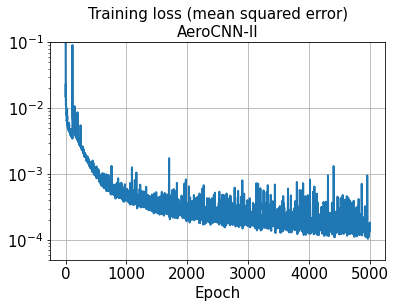

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

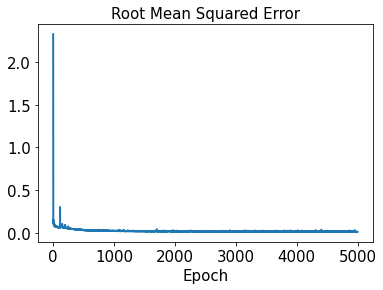

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

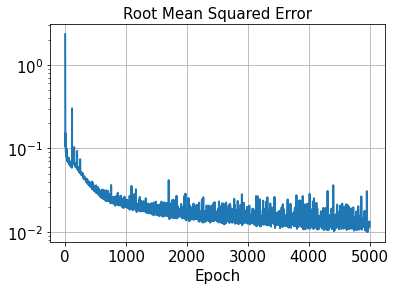

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [35]:
test_results = model.evaluate(x_train)

63/63 [==============================] - 0s 2ms/step - loss: 4.0554e-06 - rmse: 0.0000e+00


In [36]:
decoded_train = model.predict(x_train)

63/63 [==============================] - 0s 3ms/step


In [37]:
x_train.shape

(2016, 100, 100, 1)

In [38]:
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 6ms/step


In [39]:
error_train_abs = np.abs(decoded_train - y_train)

In [40]:
error_test_abs = np.abs(decoded_test - y_test)

In [41]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [42]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [43]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [44]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [45]:
decoded_train.shape

(2016, 2, 1)

In [46]:
os.chdir("D:\\TrainedModels\\20221005")
model.save('AeroCNN-II_100kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.02187010555503722


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.14877818586494837


In [49]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.019795961976203657


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.052407564504828294


In [51]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.1468334465966956


In [52]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.19333834891287185


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.019552891942997197, 0.012668941337831396, 0.021874806354079554, 0.03189932767170637, 0.04873186262216092, 0.1023135237615199, 0.012498377016568689, 0.01549967207317373, 0.006143933416770747, 0.00963880786887561, 0.03992173381404536, 0.006832353524964937, 0.04718067035708117, 0.026984588392422456, 0.029769448077587756, 0.06241778410497874, 0.036971527865183755, 0.01861909228832941, 0.011763899267223423, 0.022721932376243495, 0.05658318993848438, 0.14381459229711388, 0.02405117859239204, 0.007175983408425764, 0.021752661566959465, 0.004807021441281876, 0.07988149319940246, 0.03909775887936037, 0.01648419615287173, 0.1704382614213284, 0.07534689183936143, 0.06997095548991071, 0.019807986641924957, 0.01589124688194927, 0.02387123895404325, 0.023297850478373277, 0.09183137980541282, 0.02825677343488693, 0.0032711199126874545, 0.023806598140363504, 0.022848183818273166, 0.012698636556779396, 0.006534767088562954, 0.011614990968107464, 0.0458596390286524, 0.009412399276459508, 0.0112232485

In [54]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.030413227524287833, 0.018026713521766935, 0.049764517927293174, 0.04137134916173632, 0.24031768965407066, 0.48733862942171624, 0.0183061240614387, 0.03991109025920705, 0.10412076713777962, 0.07248556128802949, 0.2349348381953427, 0.08117815575098121, 0.036039020083769226, 0.3740102317897562, 0.1838698110342529, 0.057107750935198195, 0.0705108399234597, 0.04068084857035446, 0.02491276494273061, 0.038201530915396666, 1.7322224995221156, 0.15249564707275495, 0.07445531383453871, 0.011275091083375351, 0.03342095833183364, 0.005291691188594899, 0.01718231420924261, 0.05232953586648384, 0.118967208378668, 0.041290239945250454, 0.3224253900610383, 0.25727767829968, 0.07022922583764789, 0.07172951507496204, 0.07419670035932069, 0.11256917878433413, 0.38365585589131257, 1.502673619273214, 0.40485218185786687, 0.2761323238034001, 0.17648540309643795, 0.17138940306491054, 0.756339897889281, 0.3477770437959522, 0.019690448168976096, 0.20916668814401726, 0.016572380852897285, 0.03673770950729342

In [55]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.012995924318665636, 0.0011545146274453166, 0.015146722593732271, 0.02542480605664096, 0.009726595464557187, 0.09874436281461857, 0.010004362259110751, 0.010075478270832565, 0.002107422195894361, 0.00247132859084163, 0.01830706650919014, 0.006987687736534922, 0.048935087077282835, 0.02208117334299185, 0.031525623591317095, 0.0640482209304279, 0.03619353886187264, 0.017355072421383816, 0.00939286743913236, 0.016795823453471973, 0.05176363000064567, 0.13877043262315913, 0.02387191090223956, 0.007064035143749162, 0.02107655239308129, 0.004574326826998403, 0.07931305410390735, 0.0373884247600314, 0.003789316948038302, 0.17504867613471436, 0.07905431475317416, 0.07534497675362684, 0.004646897453181786, 0.009425375569247977, 0.0217911609345761, 0.00574819697964273, 0.09283526102549951, 0.025311976579951632, 0.0022110085061486967, 0.023814794499845023, 0.012741501289787295, 0.011528979396096043, 0.003703728395597019, 0.009294386032454902, 0.04722149809441845, 0.009839749338092485, 0.0083834

In [56]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.0660540886366426, 0.07416611275605844, 0.20254687449512648, 0.43287372002604724, 0.5647370417816744, 0.15241139133287157, 0.14800376558126654, 0.3657956246677739, 0.20716630455817556, 0.21252541756051874, 0.33187770370525205, 0.0027210793618448314, 0.010158284616662188, 0.05492126494029341, 0.006740510605045014, 0.04785379983519313, 0.05050410475380525, 0.16741661265307387, 0.20957663972388674, 0.34889944601274975, 0.24117329721619712, 0.22487126975535732, 0.05997918589990197, 0.038143639027527564, 0.18269392942017967, 0.034148584706147296, 0.09274144380504344, 0.06187726692679303, 0.05647300416977199, 0.11874725014757984, 0.0272868077334178, 0.01926955137719253, 0.08569716014904935, 0.09278542249257724, 0.22509361425193103, 0.37783185812719716, 0.07956064038645154, 0.15841384516101356, 0.06462906692459731, 0.003187690627601502, 0.8377575263032042, 0.2421276938409163, 0.2235097326367958, 0.22875303547573753, 0.009669190998441613, 0.0006774713362416127, 0.02332162940737055, 0.0042480

In [57]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.07956064038645154

In [58]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.0261452056786595, 0.014053185004209724, 0.048181096599924166, 0.03728364311900493, 0.2382392077486737, 0.4957437930842063, 0.01773652356051585, 0.03980546944066321, 0.10351700133815474, 0.07249614608811923, 0.2362841045836063, 0.08339380640908006, 0.03595305471734331, 0.38060468542613535, 0.18667371338811814, 0.059719216466639004, 0.07046566100457659, 0.0396514812585849, 0.022127286395490837, 0.03366459515108292, 2.495928876961156, 0.15290158272492155, 0.07435493632830902, 0.00924468649480707, 0.03340928228430119, 0.0018693034851653605, 0.015722544026469328, 0.004231714029426526, 0.11906444284611693, 0.041431509650043365, 0.3264813308157521, 0.2752495211397476, 0.07082614383393591, 0.07212335076111358, 0.07429137995492507, 0.11040288890086902, 0.38445527814433805, 1.5326385138193672, 0.40534893424994045, 0.2762224153096499, 0.1765640972947398, 0.17150961367077283, 0.76060792282424, 0.35171584859892724, 0.02011175873286623, 0.21474777372644194, 0.01748204019345704, 0.0377216673762597

In [59]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.07442680075171858, 0.0694963800941448, 0.17331907398920315, 0.3425615015211985, 0.3912315202511305, 0.14320846314034721, 0.09427781493162855, 0.09254930622824817, 0.2901130952071778, 0.07040308864626948, 0.18767310224395992, 0.0016971366387217395, 0.037120660244983096, 0.3032041407825712, 0.15847068283120827, 0.03570351528870151, 0.10436822707441056, 0.27294953578357845, 0.27555896839404614, 0.25360498486101346, 0.023308862595499046, 0.05582286872730872, 0.12351521334594451, 0.22888814483002237, 0.04929126177790584, 0.2066229763318252, 0.2625145703944903, 1.5516820482508629, 0.07647313438074074, 0.022953272536048182, 0.20364685057684556, 0.1169587812547171, 0.058384221679615746, 0.05349453658609045, 0.047110292828542136, 0.48415076413570907, 0.2767215120965898, 0.2084032865851475, 0.015898648800114427, 0.16962340928429726, 0.004169853255758548, 0.1063001390777312, 0.2818008610475001, 0.25992279873373114, 0.012370745668225056, 0.12858465758363902, 0.0014461901016458007, 0.02879982360

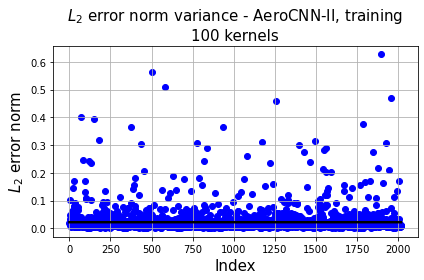

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

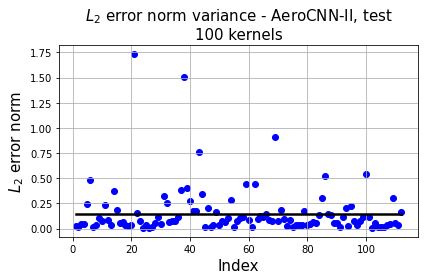

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

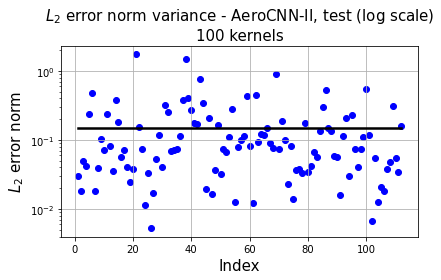

In [62]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

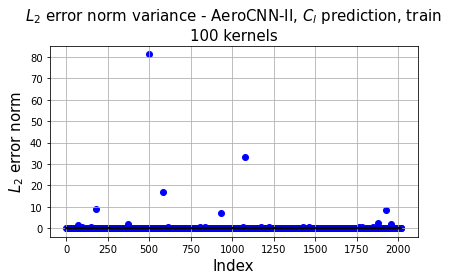

In [63]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

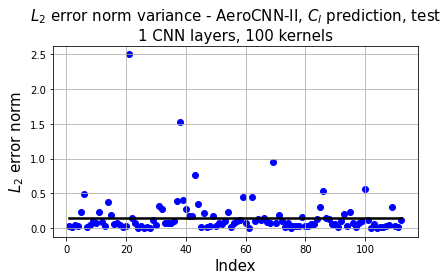

In [89]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

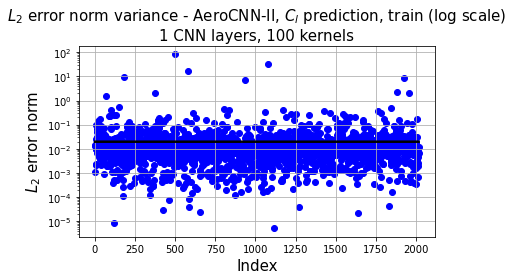

In [81]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

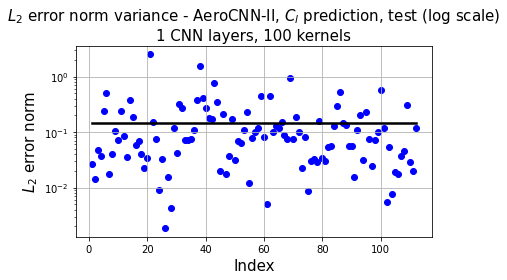

In [82]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

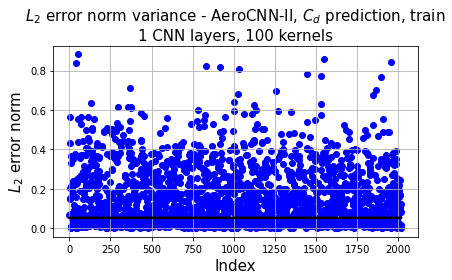

In [83]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

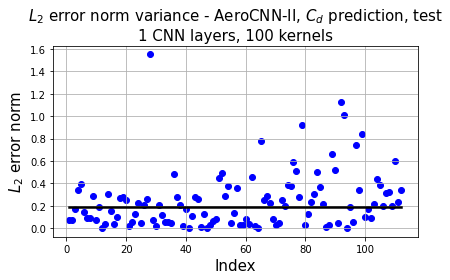

In [84]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

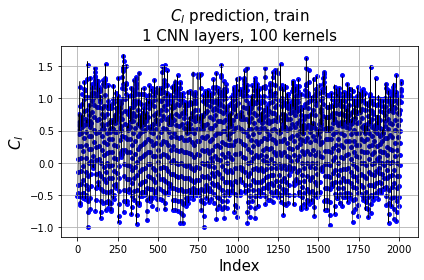

In [85]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

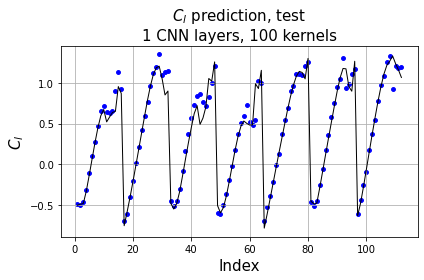

In [86]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

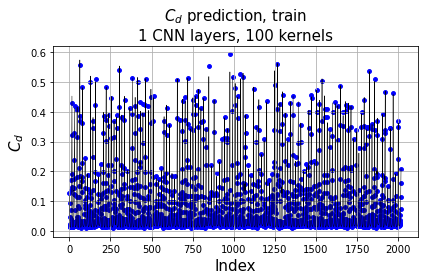

In [87]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

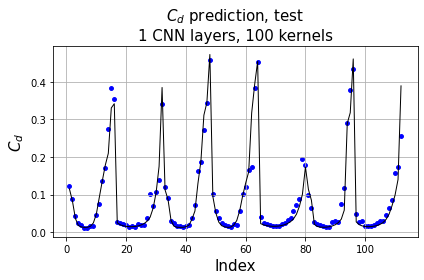

In [88]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

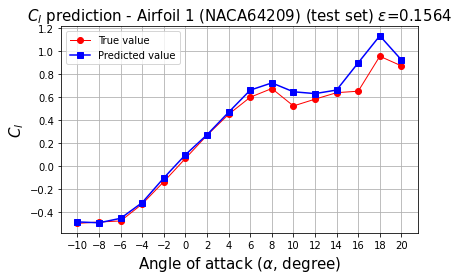

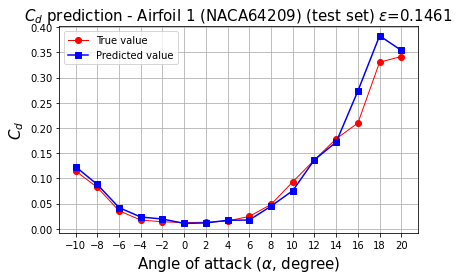

In [73]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

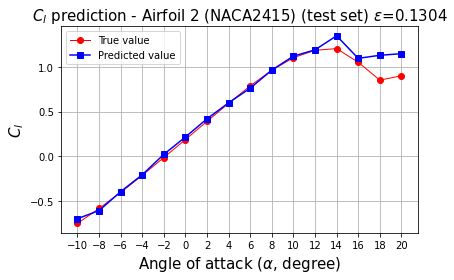

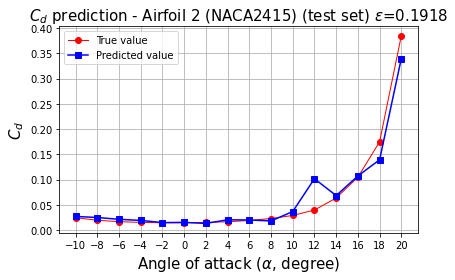

In [74]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

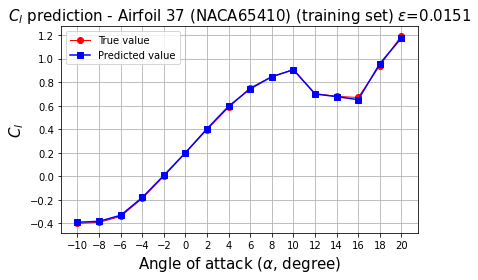

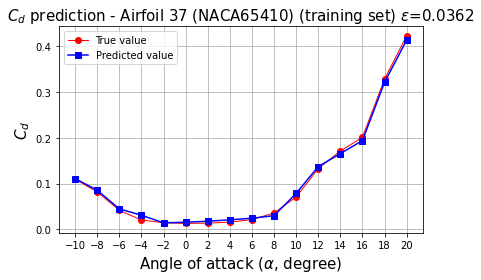

In [75]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

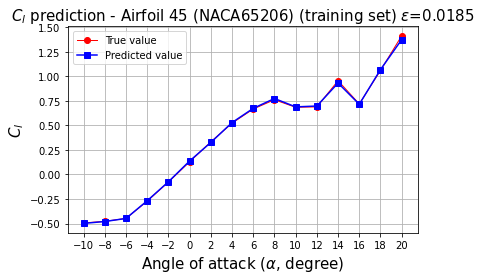

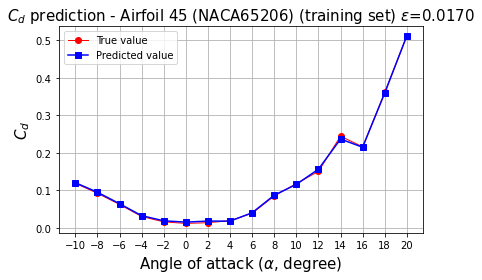

In [76]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

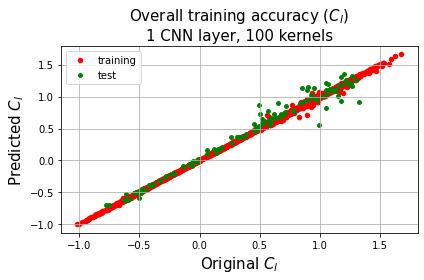

In [77]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 100 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

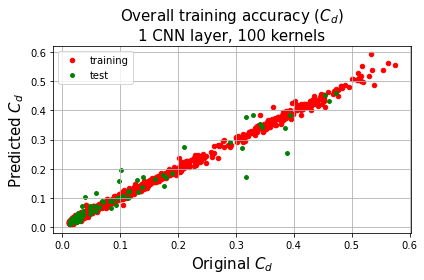

In [78]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

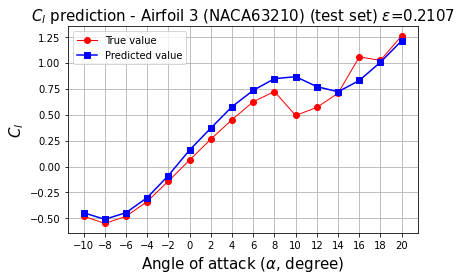

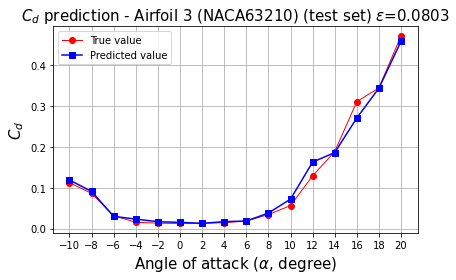

In [79]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

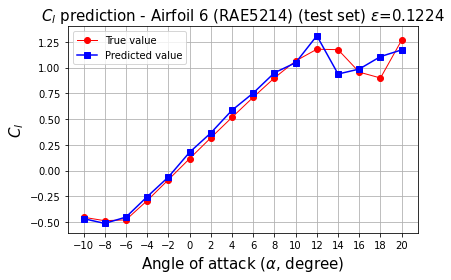

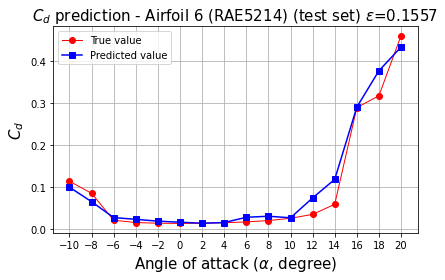

In [90]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [91]:
np.sqrt(((1.3-1.2)**2)/(1.3**2))

0.07692307692307698

In [92]:
np.sqrt(((0.45-0.59)**2)/(0.45**2))

0.311111111111111

In [93]:
np.sqrt(((-0.01-0.07)**2)/(0.01**2))

8.0